In [1]:
%matplotlib inline
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('/home/yinaihua/Desktop/时间序列/期末作业/chapter-07/USB.csv')

In [3]:
Open=data['USB.Open']
Close=data['USB.Close']

In [4]:
print(Close)

0       36.169998
1       36.200001
2       35.770000
3       35.650002
4       35.630001
5       35.610001
6       35.509998
7       35.549999
8       35.750000
9       35.759998
10      35.570000
11      35.459999
12      35.290001
13      35.400002
14      35.520000
15      35.270000
16      35.540001
17      35.380001
18      35.330002
19      35.599998
20      35.590000
21      35.810001
22      35.720001
23      36.020000
24      36.009998
25      35.930000
26      35.840000
27      36.020000
28      36.250000
29      36.200001
          ...    
3376    36.619999
3377    38.680000
3378    40.070000
3379    42.369999
3380    43.509998
3381    42.099998
3382    39.320000
3383    36.139999
3384    37.509998
3385    38.779999
3386    39.340000
3387    38.509998
3388    38.570000
3389    38.869999
3390    38.220001
3391    38.599998
3392    36.869999
3393    38.049999
3394    36.060001
3395    36.349998
3396    36.820000
3397    35.980000
3398    35.889999
3399    36.830002
3400    35

In [5]:
shoupanjia=Close[::-1]

In [6]:
print(shoupanjia)

3405    36.290001
3404    36.830002
3403    36.439999
3402    34.220001
3401    35.509998
3400    35.580002
3399    36.830002
3398    35.889999
3397    35.980000
3396    36.820000
3395    36.349998
3394    36.060001
3393    38.049999
3392    36.869999
3391    38.599998
3390    38.220001
3389    38.869999
3388    38.570000
3387    38.509998
3386    39.340000
3385    38.779999
3384    37.509998
3383    36.139999
3382    39.320000
3381    42.099998
3380    43.509998
3379    42.369999
3378    40.070000
3377    38.680000
3376    36.619999
          ...    
29      36.200001
28      36.250000
27      36.020000
26      35.840000
25      35.930000
24      36.009998
23      36.020000
22      35.720001
21      35.810001
20      35.590000
19      35.599998
18      35.330002
17      35.380001
16      35.540001
15      35.270000
14      35.520000
13      35.400002
12      35.290001
11      35.459999
10      35.570000
9       35.759998
8       35.750000
7       35.549999
6       35.509998
5       35

In [7]:
print(shoupanjia[3401:])########预测的

4    35.630001
3    35.650002
2    35.770000
1    36.200001
0    36.169998
Name: USB.Close, dtype: float64


In [8]:
shoupanjia_train=shoupanjia[0:3401]
print(len(shoupanjia_train))

3401


In [9]:
#print(shoupanjia_train)

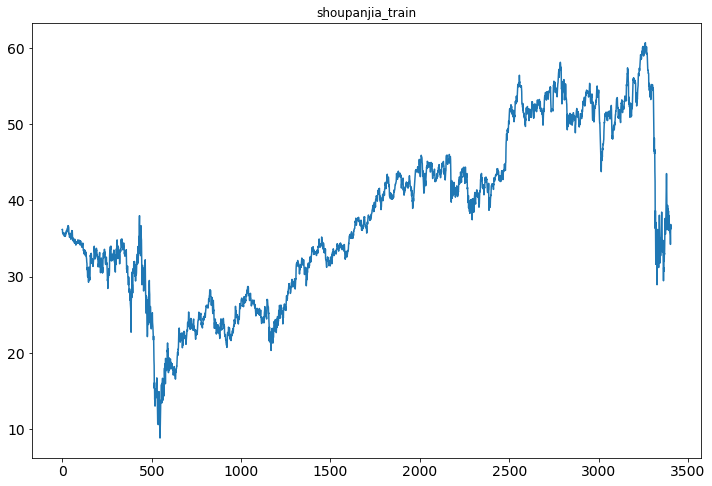

In [10]:
shoupanjia.plot(figsize=(12,8), title= 'shoupanjia_train', fontsize=14)

<Figure size 432x288 with 0 Axes>

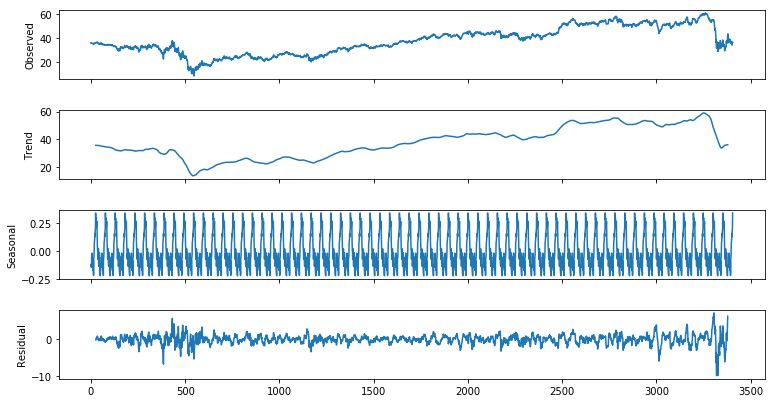

In [11]:
#########然后我们分解数据
decomposition = seasonal_decompose(shoupanjia, freq=52)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

In [12]:
########编写函数测试一下时间序列是否稳定（这个在前面ARIMA建模中已经写过，稍有不同）
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std()
 
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

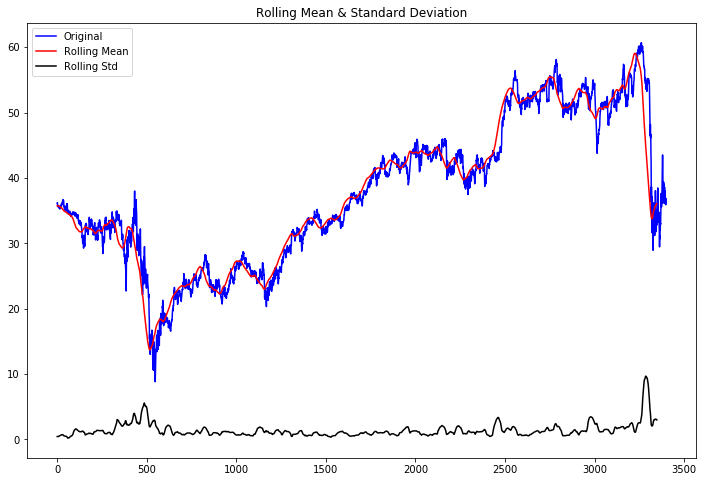

Results of Dickey-Fuller Test:
Test Statistic                   -1.460379
p-value                           0.553012
#Lags Used                       27.000000
Number of Observations Used    3372.000000
Critical Value (1%)              -3.432291
Critical Value (5%)              -2.862398
Critical Value (10%)             -2.567226
dtype: float64


In [12]:
########我们测试一下稳定性   #若统计量显著小于三个置信度且p值接近0，为平稳序列
test_stationarity(shoupanjia_train)
########从p值大于0.5和t统计量大于三个Critical Value可以得出，整体的序列并没有到达稳定性要求

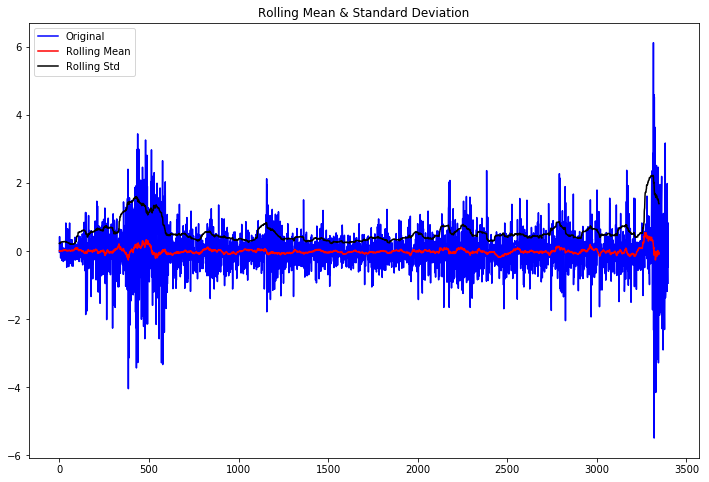

Results of Dickey-Fuller Test:
Test Statistic                -1.181560e+01
p-value                        8.653151e-22
#Lags Used                     2.600000e+01
Number of Observations Used    3.372000e+03
Critical Value (1%)           -3.432291e+00
Critical Value (5%)           -2.862398e+00
Critical Value (10%)          -2.567226e+00
dtype: float64


In [13]:
#########我们先进行一阶差分
first_difference = shoupanjia_train.diff(1)  
test_stationarity(first_difference.dropna(inplace=False))
#########一节差分后稳定

In [14]:
##确定pd的值
def queding_pq(D_data):
    ##############确定p,q值
    
    from statsmodels.tsa.arima_model import ARIMA
    #定阶
    
    #一般阶数不超过length/10
    
    #pmax = int(len(D_data)/10) 
    pmax = 6
    #一般阶数不超过length/10
    
    #qmax = int(len(D_data)/10) 
    qmax =6
    
    #bic矩阵
    
    bic_matrix = [] 
    for p in range(pmax+1):
      tmp = []
      for q in range(qmax+1):
    #存在部分报错，所以用try来跳过报错。
        try: 
          print(ARIMA(D_data, (p,1,q)).fit().bic)
          tmp.append(ARIMA(D_data, (p,1,q)).fit().bic)
        except:
          tmp.append(100000)
      bic_matrix.append(tmp)
    
    #从中可以找出最小值
    
    bic_matrix = pd.DataFrame(bic_matrix) 
    
    #先用stack展平，然后用idxmin找出最小值位置。
    
    p,q = bic_matrix.stack().idxmin() 
    
    print(u'BIC最小的p值和q值为：%s、%s' %(p,q))
    
    # 取BIC信息量达到最小的模型阶数。

In [70]:
queding_pq(shoupanjia_train)#######最佳参数是2和2

/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

6833.832461606839
6814.937070640504
6819.606486805211


6826.298273216813


6823.693045944312


6831.821550760242


6837.8772889721795


6813.442989975905


6819.884839432217


6824.895906353686


6819.511049354809


6827.629248165969


6812.060477123838


6833.173887199094


6827.563986598095


6832.331824119184


6824.092302602131


6826.08949167178


6833.787113266529


6822.6644185576715


6830.432728548182


6830.5448248587645


6831.707768923442


6815.953390188296


6830.670759917198


6832.1646118482595


6831.794794484251


6823.788831580631


6826.581002835731


6857.432564635776


6833.277565849931


6828.924773155949


6830.712957671376


6838.066406273758


6844.661366813955


6836.199300887186


BIC最小的p值和q值为：2、2


In [21]:
#通过网格搜索对seasonal_order进行定阶,目前就是pdq=011，seasonal_order=2, 2, 1, 52效果比较好，RMSE=202.4582
def get_ARIMA_params(data, pdq, m=52):#########0,0,2,52
    import itertools       
    import warnings

    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
pdq = [2, 1, 2]
get_ARIMA_params(shoupanjia_train, pdq, m=52)


x(0, 0, 0, 52)12 - AIC:6790.239344141735


x(0, 0, 1, 52)12 - AIC:6458.559926642996


x(0, 0, 2, 52)12 - AIC:5816.153942812474


x(0, 1, 0, 52)12 - AIC:8989.52985613661


x(0, 1, 1, 52)12 - AIC:6313.606120507984


In [11]:

mod = sm.tsa.statespace.SARIMAX(shoupanjia_train,
                                order=(2, 1, 2),
                                seasonal_order=(0, 0, 2, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()



In [13]:
print(mod.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          USB.Close   No. Observations:                 3401
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 52)   Log Likelihood               -2902.866
Date:                            Mon, 10 Aug 2020   AIC                           5819.733
Time:                                    10:20:34   BIC                           5862.430
Sample:                                         0   HQIC                          5835.018
                                           - 3401                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6087      0.372      1.638      0.101      -0.120       1.337
ar.L2          0.1301      0.180   

In [14]:
####评估模型预测结果
test=shoupanjia[3401:]########预测的
predictions = mod.predict(start=len(shoupanjia_train), end=len(shoupanjia_train)+len(test)-1, dynamic=False,tpy='levels')######有差分，要加typ='levels'
predictions=np.matrix(predictions)


In [25]:
test=np.matrix(test)
predictions=np.matrix(predictions)
# print(predictions[0,])
# print(test[0,])
# print(test[0,2])

for i in range(5):
    #print(test[i])
    print('predicted=%f, expected=%f' ,predictions[0,i], test[0,i])

from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=%f, expected=%f 35.600110300027694 35.630001
predicted=%f, expected=%f 35.60297737643107 35.650002
predicted=%f, expected=%f 35.59840494300382 35.77
predicted=%f, expected=%f 35.595434690605536 36.200001
predicted=%f, expected=%f 35.59828989835756 36.169998
Test MSE: 0.145
